# Deep Learning for NLP - Project

RULES:

* Do not create any additional cell

* Fill in the blanks

* All cells should be runnable (modulo trivial compatibility bugs that we'd fix)

* 4 / 20 points will be allocated to the clarity of your code

* Efficient code will have a bonus

DELIVERABLE:

* this notebook
* the predictions of the SST test set

DO NOT INCLUDE THE DATASETS IN THE DELIVERABLE..

In [2]:
import io
import os
import numpy as np
import scipy
import matplotlib.pyplot as plt

In [3]:
PATH_TO_DATA = "/Users/chalvidalm/Documents/3A OMA/Deep learning/nlp_project/data/"

# 1) Monolingual (English) word embeddings 

In [5]:
class Word2vec():
    def __init__(self, fname, nmax=100000):
        self.load_wordvec(fname, nmax)
        self.id2word = dict(enumerate(self.word2vec))
        self.word2id = {v: k for k, v in self.id2word.items()}
        self.embeddings = np.array(list(self.word2vec.values()))
    
    def load_wordvec(self, fname, nmax):
        self.word2vec = {}
        with io.open(fname, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                word, vec = line.split(' ', 1)
                self.word2vec[word] = np.fromstring(vec, sep=' ') # hypothesis : it shouldn't exist any duplicate in the parsed list
                if i == (nmax - 1):
                    break
        print('Loaded %s pretrained word vectors' % (len(self.word2vec)))

    def most_similar(self, w, K=5):
        # K most similar words: self.score  -  np.argsort 
        dic_score = {}
        if w in self.id2word.values():
            for id_ in self.word2id.values():
                dic_score[id_] = self.score(w, self.id2word[id_]) # similarity scoring
            most_similar_id = np.argsort(np.array(list(dic_score.values())))[-(K+1):] #sorting by similarity score
            most_sim = [self.id2word[i] for i in np.flip(most_similar_id) if self.id2word[i]!= w] #retrieving sentences
            return most_sim
        else:
            print("Proposed word '{}' doesn't belong to vocabulary".format(w))
            return

    def score(self, w1, w2):
        # cosine similarity: np.dot  -  np.linalg.norm
        id1, id2 = self.word2id[w1], self.word2id[w2] #retrieving word indices
        score_ = np.dot(self.embeddings[id1], self.embeddings[id2]) / (np.linalg.norm(self.embeddings[id1]) * np.linalg.norm(self.embeddings[id2])) #computing cosine similarity
        return score_


In [6]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'), nmax=100000)

# You will be evaluated on the output of the following:
for w1, w2 in zip(('cat', 'dog', 'dogs', 'paris', 'germany'), ('dog', 'pet', 'cats', 'france', 'berlin')):
    print(w1, w2, w2v.score(w1, w2))
for w1 in ['cat', 'dog', 'dogs', 'paris', 'germany']:
    print(w2v.most_similar(w1))

Loaded 100000 pretrained word vectors
cat dog 0.671683666279249
dog pet 0.684206402966922
dogs cats 0.7074389328052404
paris france 0.7775108541288563
germany berlin 0.7420295235998394
['cats', 'kitty', 'kitten', 'feline', 'kitties']
['dogs', 'puppy', 'Dog', 'doggie', 'canine']
['dog', 'pooches', 'Dogs', 'doggies', 'canines']
['france', 'Paris', 'london', 'berlin', 'tokyo']
['austria', 'europe', 'german', 'berlin', 'poland']


In [6]:
class BoV():
    def __init__(self, w2v):
        self.w2v = w2v
        #self.stopwords = set(stopwords.words('english'))
    
    def encode(self, sentences, idf=False):
        # takes a list of sentences, outputs a numpy array of sentence embeddings
        sentemb = []
        if idf == True:
            # idf-weighted mean of word vectors
            for sent in sentences:
                ids_ = []
                for word in sent.split():
                    #if word not in self.stopwords:
                    try:
                        ids_.append(self.w2v.word2id[word])
                    except:
                        pass
                vec_weighted = np.array([self.w2v.embeddings[i]*self.idf_weight[i] for i in ids_])
                sentemb.append(np.mean(vec_weighted,axis=0))
        else:
            # mean of word vectors
            for sent in sentences:
                ids_ = []
                for word in sent.split():
                    #if word not in self.stopwords:
                    try:
                        ids_.append(self.w2v.word2id[word])
                    except:
                        pass
                vec = np.array([self.w2v.embeddings[i] for i in ids_])
                sentemb.append(np.mean(vec,axis=0))
        return np.vstack(sentemb)

    def most_similar(self, s, sentences, idf=False, K=5):
        # get most similar sentences and **print** them
        scores = {}
        keys= self.encode(sentences, idf)
        query = self.encode([s], idf)
        for k, key in enumerate(keys):
            scores[k] = self.score(query,key) 
        ids_ = np.argsort(np.array(list(scores.values())).flatten())[-K:][::-1]
        return np.vstack(np.array([sentences[i] for i in ids_]))

    def score(self, s1, s2):
        # cosine similarity: use   np.dot  and  np.linalg.norm
        return np.dot(s1, s2) / (np.linalg.norm(s1) * np.linalg.norm(s2))
    
    def score_sent(self, s1, s2, idf=False):
        # using scoring with raw string sentences and encoded sentences
        s1_vec = self.encode([s1], idf)
        s2_vec = self.encode([s2], idf)
        return np.dot(s1_vec, s2_vec.T) / (np.linalg.norm(s1_vec) * np.linalg.norm(s2_vec))
    
    def build_idf(self, sentences):
        # build the idf dictionary: associate each word to its idf value
        self.idf = {}
        self.idf_weight = {}
        for sent in sentences:
            for w in set(sent.split()):
                self.idf[w] = self.idf.get(w, 0) + 1  # counting occurences
        for w in list(self.idf.keys()):
            try:
                self.idf_weight[self.w2v.word2id[w]] = max(1, np.log10(len(sentences))/(self.idf[w])) # index by ids for convenience
            except:
                pass
        return self.idf_weight

In [9]:
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'),nmax= 100000)
s2v = BoV(w2v)

# Load sentences in "PATH_TO_DATA/sentences.txt"
sentences = io.open(os.path.join(PATH_TO_DATA,'sentences.txt'), mode='r').read().splitlines()

# Build idf scores for each word
s2v.build_idf(sentences)
idf = True

# You will be evaluated on the output of the following:
print(s2v.most_similar('' if not sentences else sentences[10], sentences))  # BoV-mean
print(s2v.score_sent('' if not sentences else sentences[7], '' if not sentences else sentences[13]))

print('\n', s2v.most_similar('' if not sentences else sentences[10], sentences, idf))  # BoV-idf
print(s2v.score_sent('' if not sentences else sentences[7], '' if not sentences else sentences[13], idf))

Loaded 100000 pretrained word vectors
[['1 smiling african american boy . ']
 ['an african american man smiling . ']
 ['a little african american boy and girl looking up . ']
 ['an afican american woman standing behind two small african american children . ']
 ['an african american man is sitting . ']]
[[0.57262589]]

 [['1 smiling african american boy . ']
 ['an african american man smiling . ']
 ['a little african american boy and girl looking up . ']
 ['an afican american woman standing behind two small african american children . ']
 ['an african american man is sitting . ']]
[[0.56116265]]


# 2) Multilingual (English-French) word embeddings

Let's consider a bilingual dictionary of size V_a (e.g French-English).

Let's define **X and Y** the **French** and **English** matrices.

They contain the embeddings associated to the words in the bilingual dictionary.

We want to find a **mapping W** that will project the source word space (e.g French) to the target word space (e.g English).

Procrustes : **W = argmin || W.X - Y ||  s.t  W^T.W = Id**
has a closed form solution:
**W = U.V^T  where  U.Sig.V^T = SVD(Y.X^T)**

In what follows, you are asked to: 

In [10]:
# 1 - Download and load 50k first vectors of
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.en.vec
#     https://s3-us-west-1.amazonaws.com/fasttext-vectors/wiki.fr.vec

def reader(path, n_items):
    words_id = {}
    embeddings = []
    with io.open(path, encoding='utf-8') as f:
        next(f)
        for i, line in enumerate(f):
            word, vec = line.split(' ', 1)
            words_id[word] = i 
            embeddings.append(np.fromstring(vec, sep=' ')) 
            if i == (n_items - 1):
                break
    id_words = {v: k for k, v in words_id.items()}
    return words_id, id_words, np.array(embeddings)

en_words, en_id, en_embeddings = reader(os.path.join(PATH_TO_DATA,'wiki.en.vec'), 50000)
fr_words, fr_id, fr_embeddings = reader(os.path.join(PATH_TO_DATA,'wiki.fr.vec'), 50000)

In [11]:
# 2 - Get words that appear in both vocabs (= identical character strings)
#     Use it to create the matrix X and Y (of aligned embeddings for these words)

common_words = list(set(fr_words.keys()).intersection(en_words.keys()))
id_fr = [fr_words[i] for i in common_words]
id_en = [en_words[i] for i in common_words]
X = np.array([fr_embeddings[i] for i in id_fr]).T
Y = np.array([en_embeddings[i] for i in id_en]).T
print(X.shape)

(300, 18970)


In [12]:
# 3 - Solve the Procrustes using the scipy package and: scipy.linalg.svd() and get the optimal W
#     Now W*French_vector is in the same space as English_vector

from scipy import linalg
U, S, V = linalg.svd(Y @ X.T)
W = U @ V
fr_embeddings_eng_space = (W @ fr_embeddings.T).T


In [13]:
# 4 - After alignment with W, give examples of English nearest neighbors of some French words (and vice versa)
#     You will be evaluated on that part and the code above

from sklearn.neighbors import NearestNeighbors
NN = NearestNeighbors(5, algorithm = 'auto', metric = 'cosine')
NN.fit(en_embeddings)
strings = ['apprentissage','ordinateur', 'science', 'economie', 'jeu', 'hasard' ,'thèse']
for string in strings:
    k = fr_words[string]
    dist, test = NN.kneighbors(fr_embeddings_eng_space[:,np.newaxis][k], n_neighbors=None, return_distance=True)
    print(string, '\n', dist, '\n', [en_id[i] for i in test[0]], '\n')  

apprentissage 
 [[0.39555692 0.41664311 0.42507206 0.44421271 0.4573312 ]] 
 ['apprenticeship', 'learner', 'learning', 'learners', 'skills'] 

ordinateur 
 [[0.31621653 0.32145343 0.35557633 0.3640258  0.37790868]] 
 ['computers', 'computer', 'mainframe', 'workstation', 'programmable'] 

science 
 [[0.22228825 0.36905812 0.45069087 0.45186173 0.46096044]] 
 ['science', 'fiction', 'sciences', 'nanotechnology', 'metaphysics'] 

economie 
 [[0.36126341 0.39063097 0.41820167 0.43633842 0.44071974]] 
 ['economics', 'macroeconomics', 'economy', 'macroeconomic', 'economic'] 

jeu 
 [[0.26429006 0.29007032 0.34939323 0.3520151  0.35992946]] 
 ['gameplay', 'game', 'videogame', 'dreamcast', 'multiplayer'] 

hasard 
 [[0.56188441 0.58619875 0.60054803 0.60160312 0.60586933]] 
 ['randomly', 'fait', 'randomness', 'random', 'poisson'] 

thèse 
 [[0.23382457 0.30056705 0.37234694 0.39335806 0.4104942 ]] 
 ['thesis', 'dissertation', 'doctoral', 'phd', 'habilitation'] 



If you want to dive deeper on this subject: https://github.com/facebookresearch/MUSE

# 3) Sentence classification with BoV and scikit-learn

In [4]:
# 1 - Load train/dev/test of Stanford Sentiment TreeBank (SST)
#     (https://nlp.stanford.edu/~socherr/EMNLP2013_RNTN.pdf)

SST_train_path = 'SST/stsa.fine.train'
SST_dev_path = 'SST/stsa.fine.dev'
SST_test_path = 'SST/stsa.fine.test.X'

def SST_reader(path, test=False):
    sentences = []
    categories = []
    if test==False:
        with io.open(path, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                category, sentence = line.split(' ', 1)
                sentences.append(sentence.strip('\n'))
                categories.append(category)
        return [categories, sentences]
    else:
        with io.open(path, encoding='utf-8') as f:
            next(f)
            for i, line in enumerate(f):
                sentences.append(line.strip('\n'))
        return sentences
    
SST_train = SST_reader(os.path.join(PATH_TO_DATA,SST_train_path))
SST_dev = SST_reader(os.path.join(PATH_TO_DATA,SST_dev_path))
SST_test = SST_reader(os.path.join(PATH_TO_DATA,SST_test_path), True)

In [7]:
# 2 - Encode sentences with the BoV model above

# TYPE CODE HERE
w2v = Word2vec(os.path.join(PATH_TO_DATA, 'crawl-300d-200k.vec'),nmax= 100000)
s2v = BoV(w2v)
s2v.build_idf(SST_train[1]+SST_dev[1]+SST_test)

SST_train_encoded_noidf = s2v.encode(SST_train[1], idf=False)
SST_dev_encoded_noidf = s2v.encode(SST_dev[1], idf=False)
SST_test_encoded_noidf = s2v.encode(SST_test, idf=False)

SST_train_encoded = s2v.encode(SST_train[1], idf=True)
SST_dev_encoded = s2v.encode(SST_dev[1], idf=True)
SST_test_encoded = s2v.encode(SST_test, idf=True)

Loaded 100000 pretrained word vectors


In [16]:
# 3 - Learn Logistic Regression on top of sentence embeddings using scikit-learn
#     (consider tuning the L2 regularization on the dev set)

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
parameters = {'C':[i*0.1 for i in range(1,10)], 'penalty':['l2'], 'tol':[1e-6] , 'max_iter':[10000], 'solver':['lbfgs'] , 'multi_class':['multinomial']}
logreg = LogisticRegression()
clf = GridSearchCV(logreg, parameters, cv=5)
clf.fit(SST_train_encoded,SST_train[0])
print(dict(zip([i*0.1 for i in range(1,10)],clf.cv_results_['mean_test_score']))) # 10 seems a good trade-off for regularization parameter

model_noidf =  LogisticRegression(C= 0.2, penalty ='l2', tol=1e-6 , max_iter=10000, solver='lbfgs' , multi_class='multinomial')
model_noidf.fit(SST_train_encoded_noidf,SST_train[0])

model =  LogisticRegression(C= 0.2, penalty ='l2', tol=1e-6 , max_iter=10000, solver='lbfgs' , multi_class='multinomial')
model.fit(SST_train_encoded,SST_train[0])


{0.1: 0.4252604471497132, 0.2: 0.42970853330211867, 0.8: 0.42151469038979283, 0.30000000000000004: 0.4288891490108861, 0.9: 0.4213976354910453, 0.6000000000000001: 0.4212805805922978, 0.7000000000000001: 0.42174880018728783, 0.4: 0.42397284326349055, 0.5: 0.42373873346599555}


LogisticRegression(C=0.2, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=10000, multi_class='multinomial',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=1e-06, verbose=0, warm_start=False)

In [17]:
from sklearn.metrics import accuracy_score, f1_score


print('accuracy on training set no_idf: ',accuracy_score(SST_train[0],model_noidf.predict(SST_train_encoded_noidf)))
print('f_1 score on training set no_idf: ',f1_score(SST_train[0],model_noidf.predict(SST_train_encoded_noidf),average='weighted'))
print('\n')
print('accuracy on dev set no_idf: ',accuracy_score(SST_dev[0],model_noidf.predict(SST_dev_encoded_noidf)))
print('f_1 score on dev set no_idf: ',f1_score(SST_dev[0],model_noidf.predict(SST_dev_encoded_noidf),average='weighted'))
print('\n')
print('accuracy on training set idf: ',accuracy_score(SST_train[0],model.predict(SST_train_encoded)))
print('f_1 score on training set idf: ',f1_score(SST_train[0],model.predict(SST_train_encoded),average='weighted'))
print('\n')
print('accuracy on dev set idf: ', accuracy_score(SST_dev[0],model.predict(SST_dev_encoded)))
print('f_1 score on dev set idf: ', f1_score(SST_dev[0],model.predict(SST_dev_encoded),average='weighted'))

from sklearn.metrics import confusion_matrix 
print(confusion_matrix(SST_dev[0],model_noidf.predict(SST_dev_encoded_noidf)))


accuracy on training set no_idf:  0.4716141870537282
f_1 score on training set no_idf:  0.4273507129999741


accuracy on dev set no_idf:  0.43
f_1 score on dev set no_idf:  0.37533626044703106


accuracy on training set idf:  0.4744235046236685
f_1 score on training set idf:  0.4374165268905858


accuracy on dev set idf:  0.4118181818181818
f_1 score on dev set idf:  0.36524141429201595
[[ 17 100   5  15   2]
 [  9 193  11  76   0]
 [  4  99  14 107   4]
 [  2  52   7 199  19]
 [  0  11   1 103  50]]


In [18]:
# 4 - Produce 2210 predictions for the test set (in the same order). One line = one prediction (=0,1,2,3,4).
#     Attach the output file "logreg_bov_y_test_sst.txt" to your deliverable.
#     You will be evaluated on the results of the test set.

# TYPE CODE HERE
predictions = model_noidf.predict(SST_test_encoded)
with io.open("logreg_bov_y_test_sst.txt","w+") as f:
    for classe in predictions:
        f.write(classe + '\n')
    f.close

In [19]:
# BONUS!
# 5 - Try to improve performance with another classifier
#     Attach the output file "XXX_bov_y_test_sst.txt" to your deliverable (where XXX = the name of the classifier)

# TYPE CODE HERE
from sklearn.svm import SVC
SVC = SVC(kernel ='rbf', C=10, tol = 1e-4 ,max_iter = 1000)
SVC.fit(SST_train_encoded,SST_train[0])
print(accuracy_score(SST_dev[0],SVC.predict(SST_dev_encoded)))
print(f1_score(SST_dev[0],SVC.predict(SST_dev_encoded),average='weighted'))

//anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)
//anaconda/lib/python3.5/site-packages/sklearn/svm/base.py:244: ConvergenceWarning: Solver terminated early (max_iter=1000).  Consider pre-processing your data with StandardScaler or MinMaxScaler.
  % self.max_iter, ConvergenceWarning)


0.3090909090909091
0.24111166713595578


//anaconda/lib/python3.5/site-packages/sklearn/metrics/classification.py:1143: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


# 4) Sentence classification with LSTMs in Keras

## 4.1 - Preprocessing

In [8]:
import keras

Using TensorFlow backend.


In [9]:
# 1 - Load train/dev/test sets of SST

SST_train_path = 'SST/stsa.fine.train'
SST_dev_path = 'SST/stsa.fine.dev'
SST_test_path = 'SST/stsa.fine.test.X'

SST_train = SST_reader(os.path.join(PATH_TO_DATA,SST_train_path))
SST_dev = SST_reader(os.path.join(PATH_TO_DATA,SST_dev_path))
SST_test = SST_reader(os.path.join(PATH_TO_DATA,SST_test_path), True)

In [89]:
# 2 - Transform text to integers using keras.preprocessing.text.one_hot function
#     https://keras.io/preprocessing/text/

# TYPE CODE HERE
from keras.preprocessing.text import one_hot
voc = [token for sentence in SST_train[1] for token in sentence.split()] + [token for sentence in SST_dev[1] for token in sentence.split()] + [token for sentence in SST_test[1] for token in sentence.split()] 
n_voc = len(np.unique(voc))
n_hash = int(1.3*n_voc)+1
Onehot_train = []
Onehot_dev = []
for sentence in SST_train[1]:
    
    Onehot_train.append(one_hot(sentence, n_hash, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~  ', lower=True, split=' '))

for sentence in SST_dev[1]:
    Onehot_dev.append(one_hot(sentence, n_hash, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~  ', lower=True, split=' '))

print('n voc: ', n_voc)   

print('\n','one hot')   
print('unique tokens one-hot encoded:', len(np.unique([token for sentence in Onehot_train for token in sentence])))
print('value max:', (np.max([token for sentence in Onehot_train for token in sentence])))

## Tokenizer 
from keras.preprocessing.text import Tokenizer
Tok = Tokenizer(n_voc, filters = '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~  ', lower=True, split=' ')
Tok.fit_on_texts(SST_train[1])
Tokens_train = []
Tokens_dev = []

Tokens_train = Tok.texts_to_sequences(SST_train[1])
Tokens_dev = Tok.texts_to_sequences(SST_dev[1])

print('\n','tokenizing')  
print('unique tokens tokenizing encoded:', np.max([token for sentence in Tokens_train for token in sentence]))
print('value max:', np.max([token for sentence in Onehot_train for token in sentence]))


### Manual tokenizer 
Encoding_dic ={}
filters=[i for i in '!"#$%&()*+,-./:;<=>?@[\]^_`{|}~  ']

for i, token in enumerate(set(voc)):
    Encoding_dic[token] = i 

Encoding_train = []
for sentence in SST_train[1]:
    Encoding_train.append([Encoding_dic.get(token,0) for token in sentence.split(' ')])
    
Encoding_dev = []
for sentence in SST_dev[1]:
    Encoding_dev.append([Encoding_dic.get(token,0) for token in sentence.split(' ')])

print('\n','manual tokenizing')  
print('unique tokens manual tokenizing encoded:', len(np.unique([token for sentence in Encoding_train for token in sentence])))
print('value max:', np.max([token for sentence in Encoding_train for token in sentence]))

Encoding_test = []
for sentence in SST_test:
    Encoding_test.append([Encoding_dic.get(token,0) for token in sentence.split(' ')])


n voc:  17612

 one hot
unique tokens one-hot encoded: 11148
value max: 22895

 tokenizing
unique tokens tokenizing encoded: 15335
value max: 22895

 manual tokenizing
unique tokens manual tokenizing encoded: 16577
value max: 17611


**Padding input data**

Models in Keras (and elsewhere) take batches of sentences of the same length as input. It is because Deep Learning framework have been designed to handle well Tensors, which are particularly suited for fast computation on the GPU.

Since sentences have different sizes, we "pad" them. That is, we add dummy "padding" tokens so that they all have the same length.

The input to a Keras model thus has this size : (batchsize, maxseqlen) where maxseqlen is the maximum length of a sentence in the batch.

In [90]:
# 3 - Pad your sequences using keras.preprocessing.sequence.pad_sequences
#     https://keras.io/preprocessing/sequence/

# TYPE CODE HERE
from keras.preprocessing.sequence import pad_sequences
pad_length = np.max([len(sentence) for sentence in Encoding_train])
Padded_train = pad_sequences(Encoding_train, maxlen=pad_length, dtype='int32', padding='post', truncating='pre', value=0)
Padded_dev = pad_sequences(Encoding_dev, maxlen=pad_length, dtype='int32', padding='post', truncating='pre', value=0)
Padded_test = pad_sequences(Encoding_test, maxlen=pad_length, dtype='int32', padding='post', truncating='pre', value=0)



## 4.2 - Design and train your model

In [80]:
# 4 - Design your encoder + classifier using keras.layers
#     In Keras, Torch and other deep learning framework, we create a "container" which is the Sequential() module.
#     Then we add components to this contained : the lookuptable, the LSTM, the classifier etc.
#     All of these components are contained in the Sequential() and are trained together.


# ADAPT CODE BELOW

from keras.models import Sequential
from keras.layers import Embedding, LSTM, Dense, Activation, Bidirectional, MaxPooling1D, Dropout, Flatten

embed_dim  = 300  # word embedding dimension
nhid       = 50  # number of hidden units in the LSTM
vocab_size = n_voc # size of the vocabulary
n_classes  = 5

model = Sequential()
model.add(Embedding(vocab_size, embed_dim, mask_zero=True,trainable=True))
model.add(Dropout(0.5))
model.add(Bidirectional(LSTM(nhid, dropout=0.5, recurrent_dropout=0.5)))
model.add(Dense(50,activation='tanh'))
model.add(Dense(n_classes, activation='softmax'))


In [81]:
# 5 - Define your loss/optimizer/metrics

# MODIFY CODE BELOW

loss_classif     =  'categorical_crossentropy' # find the right loss for multi-class classification
optimizer        =  'RMSProp' # find the right optimizer
metrics_classif  =  ['accuracy']

# Observe how easy (but blackboxed) this is in Keras
model.compile(loss=loss_classif,
              optimizer=optimizer,
              metrics=metrics_classif)
print(model.summary())

y_train = keras.utils.to_categorical(SST_train[0], num_classes=5)
y_dev = keras.utils.to_categorical(SST_dev[0], num_classes=5)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_19 (Embedding)     (None, None, 300)         6868800   
_________________________________________________________________
dropout_14 (Dropout)         (None, None, 300)         0         
_________________________________________________________________
bidirectional_16 (Bidirectio (None, 100)               140400    
_________________________________________________________________
dense_27 (Dense)             (None, 50)                5050      
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 255       
Total params: 7,014,505
Trainable params: 7,014,505
Non-trainable params: 0
_________________________________________________________________
None


In [82]:
# 6 - Train your model and find the best hyperparameters for your dev set
#     you will be evaluated on the quality of your predictions on the test set

# ADAPT CODE BELOW
bs = 256
n_epochs = 5
history = model.fit(Padded_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(Padded_dev, y_dev))

Train on 8543 samples, validate on 1100 samples
Epoch 1/5
8543/8543 [==============================] - 61s - loss: 1.5668 - acc: 0.2889 - val_loss: 1.5523 - val_acc: 0.3118
Epoch 2/5
8543/8543 [==============================] - 53s - loss: 1.4884 - acc: 0.3564 - val_loss: 1.4395 - val_acc: 0.3636
Epoch 3/5
8543/8543 [==============================] - 50s - loss: 1.3404 - acc: 0.4313 - val_loss: 1.3658 - val_acc: 0.3973
Epoch 4/5
8543/8543 [==============================] - 50s - loss: 1.2020 - acc: 0.4917 - val_loss: 1.3320 - val_acc: 0.4109
Epoch 5/5
8543/8543 [==============================] - 49s - loss: 1.0898 - acc: 0.5526 - val_loss: 1.3383 - val_acc: 0.4091


[[ 31  82  14   9   3]
 [ 24 180  28  53   4]
 [  8  95  26  95   4]
 [  7  47  29 175  21]
 [  0  15  11 101  38]]


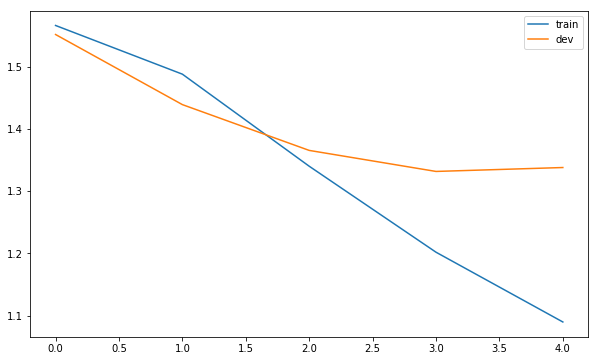

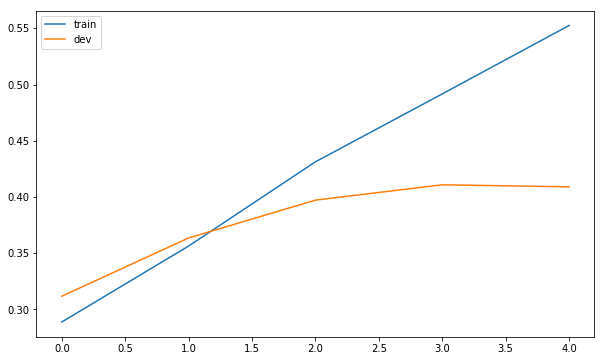

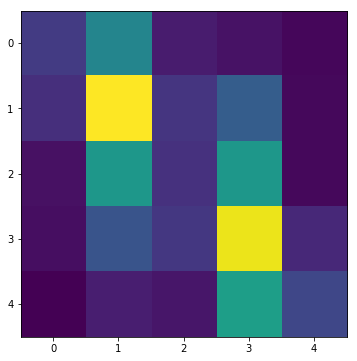

In [101]:
# 7 - Generate your predictions on the test set using model.predict(x_test)
#     https://keras.io/models/model/
#     Log your predictions in a file (one line = one integer: 0,1,2,3,4)
#     Attach the output file "logreg_lstm_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE
plt.subplots(figsize=(10,6))
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','dev'])
plt.savefig('loss')

plt.subplots(figsize=(10,6))
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.legend(['train','dev'])
plt.savefig('acc')

from sklearn.metrics import confusion_matrix
plt.subplots(figsize=(10,6))
print(confusion_matrix(SST_dev[0],(np.argmax(model.predict(Padded_dev),axis=1).astype(str))))
plt.imshow(confusion_matrix(SST_dev[0],(np.argmax(model.predict(Padded_dev),axis=1).astype(str))))

predictions = model.predict(Padded_test)
with io.open("logreg_lstm_y_test_sst.txt","w+") as f:
    for classe in np.argmax(predictions,axis=1).astype(str):
        f.write(classe + '\n')
    f.close

## 4.3 -- innovate !

In [126]:
# 8 - Open question: find a model that is better on your dev set
#     (e.g: use a 1D ConvNet, use a better classifier, pretrain your lookup tables ..)
#     you will get point if the results on the test set are better: be careful of not overfitting your dev set too much..
#     Attach the output file "XXX_XXX_y_test_sst.txt" to your deliverable.

# TYPE CODE HERE

from keras.layers import Input, Dense, concatenate, Activation, Conv1D, GlobalMaxPooling1D, Dropout
from keras.models import Model

_input = Input(shape=(52,), dtype='int32')
encoder = Embedding(100000, 300, weights=[w2v.embeddings])(_input)
encoder = Dropout(0.5)(encoder)
bigram_branch = Conv1D(filters=100, kernel_size=2, padding='valid', activation='relu', strides=1)(encoder)
bigram_branch = GlobalMaxPooling1D()(bigram_branch)
trigram_branch = Conv1D(filters=100, kernel_size=3, padding='valid', activation='relu', strides=1)(encoder)
trigram_branch = GlobalMaxPooling1D()(trigram_branch)
fourgram_branch = Conv1D(filters=100, kernel_size=4, padding='valid', activation='relu', strides=1)(encoder)
fourgram_branch = GlobalMaxPooling1D()(fourgram_branch)
merged = concatenate([bigram_branch, trigram_branch, fourgram_branch], axis=1)
merged = Dropout(0.5)(merged)
merged = Dense(256, activation='tanh')(merged)
merged = Dropout(0.5)(merged)
output = Dense(5, activation = 'softmax')(merged)

CNN = Model(inputs=[_input], outputs=[output])
CNN.compile(loss='categorical_crossentropy',
                  optimizer='adam',
                  metrics=['accuracy'])
CNN.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_13 (InputLayer)            (None, 52)            0                                            
____________________________________________________________________________________________________
embedding_36 (Embedding)         (None, 52, 300)       30000000    input_13[0][0]                   
____________________________________________________________________________________________________
dropout_31 (Dropout)             (None, 52, 300)       0           embedding_36[0][0]               
____________________________________________________________________________________________________
conv1d_32 (Conv1D)               (None, 51, 100)       60100       dropout_31[0][0]                 
___________________________________________________________________________________________

In [127]:
bs = 256
n_epochs = 20
history = CNN.fit(Padded_train, y_train, batch_size=bs, epochs=n_epochs, validation_data=(Padded_dev, y_dev))

predictions = CNN.predict(Padded_test)
with io.open("CNN_y_test_sst.txt","w+") as f:
    for classe in np.argmax(predictions,axis=1).astype(str):
        f.write(classe + '\n')
    f.close

Train on 8543 samples, validate on 1100 samples
Epoch 1/20
8543/8543 [==============================] - 123s - loss: 2.1320 - acc: 0.2281 - val_loss: 1.6160 - val_acc: 0.2527
Epoch 2/20
8543/8543 [==============================] - 56s - loss: 1.9383 - acc: 0.2309 - val_loss: 1.5967 - val_acc: 0.2518
Epoch 3/20
8543/8543 [==============================] - 57s - loss: 1.8086 - acc: 0.2396 - val_loss: 1.5730 - val_acc: 0.3018
Epoch 4/20
8543/8543 [==============================] - 58s - loss: 1.7284 - acc: 0.2465 - val_loss: 1.5394 - val_acc: 0.3118
Epoch 5/20
8543/8543 [==============================] - 56s - loss: 1.6730 - acc: 0.2564 - val_loss: 1.5505 - val_acc: 0.3082
Epoch 6/20
8543/8543 [==============================] - 60s - loss: 1.6291 - acc: 0.2730 - val_loss: 1.5270 - val_acc: 0.3218
Epoch 7/20
8543/8543 [==============================] - 56s - loss: 1.5934 - acc: 0.2840 - val_loss: 1.5232 - val_acc: 0.3218
Epoch 8/20
8543/8543 [==============================] - 55s - loss: 1

[[ 29  65  32   8   5]
 [ 25 127  81  47   9]
 [  9  49  84  66  20]
 [  8  35  50 120  66]
 [  3   9  16  64  73]]


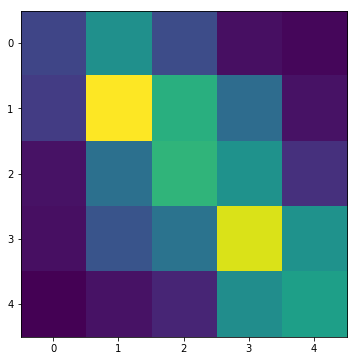

In [132]:
plt.subplots(figsize=(10,6))
print(confusion_matrix(SST_dev[0],(np.argmax(CNN.predict(Padded_dev),axis=1).astype(str))))
plt.imshow(confusion_matrix(SST_dev[0],(np.argmax(CNN.predict(Padded_dev),axis=1).astype(str))))
